## Project Overview: Training an Image Classifier for Flower Species

In this project, I’ll be building an **image classifier** to recognize different species of flowers. To do this, I’ll train the classifier, fine-tune it, and then export it for use in an application.


### Dataset ###
- I’ll be working with the [102 Category Flower Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html), which contains images of flowers from 102 unique categories.
- The dataset should already be included with this notebook, but if it’s missing, it can be [downloaded here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz).

 Below is an example from the dataset:

<img src='assets/Flowers.png' width=500px>

### Steps I'll Follow

I’ll break the project into the following steps:

1. **Load and preprocess the image dataset**  
   I’ll prepare the dataset for training by resizing, normalizing, and augmenting the images.

2. **Train the image classifier**  
   I’ll build and train a neural network model to recognize different flower species using the preprocessed dataset.

3. **Make predictions with the trained classifier**  
   Once trained, I’ll use the model to predict the species of flowers from new images.


### What I Aim to Achieve
When I’m done, I’ll have a functional application that can be trained on any set of labeled images. While I’m focusing on flowers here, I can apply the same skills to other datasets. 

In [18]:
# Imports here
import os
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import VGG16_Weights
from PIL import Image
import numpy as np
import json

## Data Loading and Preprocessing

To handle the dataset, I’ll use `torchvision` for loading and transforming the data. The dataset is organized into three parts: **training**, **validation**, and **testing**. Here’s how I’ll preprocess each part:

### Training Data
For the training set, I’ll apply data augmentation techniques such as:
- **Random scaling**: Adjusting the size of the images randomly.
- **Cropping**: Taking random crops from the images.
- **Flipping**: Applying random horizontal flips.

These transformations will help the network generalize better by introducing variety in the input data. Additionally, all images will be resized to **224x224 pixels**, the required input size for the pre-trained networks.

### Validation and Testing Data
The validation and testing sets will be used to evaluate the model's performance on unseen data. For these sets, I won’t apply random transformations like scaling or flipping. Instead, I’ll:
- Resize the images.
- Center-crop them to **224x224 pixels**.

### Normalization
The pre-trained networks I’ll be using were trained on the **ImageNet dataset**, where each color channel was normalized individually. To match the network’s expectations, I’ll normalize all three datasets (training, validation, and testing) using the following values:
- **Means**: `[0.485, 0.456, 0.406]`
- **Standard deviations**: `[0.229, 0.224, 0.225]`

This normalization centers each color channel at 0 and scales the values to range between -1 and 1. It ensures that the input data aligns with the pre-trained network’s parameters, improving the model's performance.


In [19]:
data_dir = 'flower_data'
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

In [20]:
# Define your transforms for the training, validation, and testing sets
train_transform =  transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

valid_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder( train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder( valid_dir, transform=valid_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Using the image datasets and the transform, define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

## Label Mapping

To make the predictions more interpretable, I’ll load a mapping from category labels to category names. This mapping is provided in the file `cat_to_name.json`. Once loaded, this will provide a dictionary that maps the integer-encoded category labels to their corresponding flower names. 

This step ensures that the model’s predictions are presented in a user-friendly format, showing the actual names of the flowers rather than numerical labels.


In [21]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

## Building and Training the Classifier

With the data preprocessed and ready, it’s time to build and train the image classifier. I’ll use one of the **pre-trained models** from `torchvision.models` to leverage the powerful image features these networks provide. Then, I’ll build and train a custom feed-forward classifier on top of the pre-trained features.

### Steps to Complete

Here’s a breakdown of the tasks for this section:

1. **Load a pre-trained network**  
   Use a model from the [torchvision models library](http://pytorch.org/docs/master/torchvision/models.html). The **VGG networks** is a great starting point due to it's simplicity and effectiveness.

2. **Define a new feed-forward network**  
   Build a new, untrained feed-forward network to act as the classifier. Use:
   - **ReLU activations** for the hidden layers.
   - **Dropout** to prevent overfitting.

3. **Train the classifier**  
   - Use **backpropagation** to train the classifier layers while freezing the weights of the pre-trained network.
   - Ensure that only the weights of the feed-forward network are updated during training.

4. **Track performance**  
   Monitor the **loss** and **accuracy** on the validation set during training to find the best combination of hyperparameters.


### Training Reminders
- Experiment with different hyperparameters like:
  - Learning rate
  - Number of units in the classifier layers
  - Number of epochs
  - Dropout rates
- Aim for a **validation accuracy of at least 70%**.

The model is saved for later use

In [22]:
# Build and train your network
# Load the pretrained model
model = models.vgg16(weights=VGG16_Weights.DEFAULT)

# freeze parameters to avoid updating them during training
for param in model.parameters():
    param.requires_grad = False

In [23]:
# Define the new classifier
classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024,102),
    nn.LogSoftmax(dim=1)
)

# Replacing the classifier in the model
model.classifier = classifier


In [24]:
#Define the loss function and optimizer
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

In [25]:
def validation(model, loader, criterion):
    """
        validation of model against test/validation data
    """
    model.eval()  # Set model to evaluation mode
    loss = 0
    accuracy = 0
    with torch.no_grad():  # Disable gradient calculations for validation
        for images, labels in loader:

            output = model(images)
            loss += criterion(output, labels).item()

            # Calculate accuracy
            ps = torch.exp(output)
            top_class = ps.topk(1, dim=1)[1]
            equals = top_class == labels.view(*top_class.shape)
            accuracy += equals.float().mean().item()
            
    # calculate average loss and accuracy
    loss = loss/len(loader)
    accuracy = accuracy/len(loader)
    
    return loss, accuracy

In [26]:
## Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 3
for epoch in range(epochs):
    model.train()
    running_loss = 0

    # Training Loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # clear the gradients
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Validation loop
    val_loss, val_accuracy = validation(model, val_loader, criterion )

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Training Loss: {running_loss/len(train_loader):.3f}.. "
          f"Validation Loss: {val_loss:.3f}.. "
          f"Validation Accuracy: {val_accuracy*100:.2f}%")

Epoch 1/3.. Training Loss: 2.883.. Validation Loss: 1.060.. Validation Accuracy: 72.30%
Epoch 2/3.. Training Loss: 1.266.. Validation Loss: 0.626.. Validation Accuracy: 84.17%
Epoch 3/3.. Training Loss: 0.960.. Validation Loss: 0.522.. Validation Accuracy: 85.17%


## Testing Your Network

After training the classifier, I evaluate its performance on a **test dataset**, consisting of images the network has never seen before. This step ensures the model generalizes well to completely new data. Testing on a separate dataset ensures that the model performs reliably and isn’t overfitting the training or validation data.

### Steps for Testing

1. **Prepare the test dataset**  
   Ensure the test data has been preprocessed the same way as the validation data, including resizing, cropping, and normalization.

2. **Run the test images through the trained network**  
   Use the trained model to make predictions on the test dataset.

3. **Measure performance**  
   Calculate the accuracy of the network by comparing its predictions with the true labels of the test images. This can be done in the same way as during validation, by:
   - Tracking the number of correct predictions.
   - Dividing it by the total number of test samples.

### Expected Results

If the model has been trained well, you should achieve **around 70% accuracy** on the test set.



In [27]:
test_loss, test_accuracy = validation(model, test_loader, criterion )

print(f"Test Loss: {test_loss:.3f}.. "
      f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Loss: 0.654.. Test Accuracy: 82.15%


## Save the Checkpoint

Once the network is trained, I save the model so it can be loaded later for making predictions or continuing training. A checkpoint allows you to store all necessary information to rebuild the model and resume where you left off.

### What to Save

1. **Model architecture and state**  
   Save the model's state dictionary, which contains the trained weights and biases.

2. **Class-to-index mapping**  
   Store the mapping of classes to indices, which can be retrieved from the training dataset:
   ```python
   model.class_to_idx = image_datasets['train'].class_to_idx


In [28]:
# Save the checkpoint 
checkpoint = {
        'input_size': 25088,
        'output_size': 102,
        'epochs': epochs,
        'learning_rate': learning_rate,
        'classifier': model.classifier,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'class_to_idx': train_dataset.class_to_idx
    }
torch.save(checkpoint, 'model_checkpoint.pth')

## Loading the Checkpoint

To make the model reusable, I wrote a function that can **load a checkpoint** and rebuild the model. This way project work can resume without having to retrain the network from scratch.

### Function: `load_checkpoint`

The function will:
1. Load the saved checkpoint file.
2. Extract the model architecture, classifier, and saved state dictionaries.
3. Rebuild the model, including reloading the trained weights and any additional attributes like `class_to_idx`.


In [29]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    """
    Load a checkpoint and rebuild model
    """
    checkpoint = torch.load(filepath, weights_only=False)
    output_size = checkpoint['output_size']
    state_dict = checkpoint['model_state_dict']
    class_to_idx = checkpoint['class_to_idx']
    classifier = checkpoint['classifier']
    
    model = models.vgg16(weights=VGG16_Weights.DEFAULT)

    # freeze parameters to avoid updating them during training
    for param in model.parameters():
        param.requires_grad = False

    # Replacing the classifier in the model
    model.classifier = classifier
    model.load_state_dict( state_dict)
    model.class_to_idx = class_to_idx

    model.eval()

    return model

## Inference for Classification

Now that the model is trained, I'll create a function to use it for inference. This function will take an image, process it, and predict the flower's class. The goal is to return the top $K$ most likely classes along with their probabilities.

To prepare the image for the model, I'll implement the following steps:

1. **Load the image**: 
Use the PIL library to load the image (Pillow documentation).
2. **Resize the image**:
Resize the shortest side to 256 pixels while maintaining the aspect ratio. This can be achieved using the thumbnail or resize method from PIL.
3. **Crop the center**:
Extract the central 224x224 pixels from the resized image to match the input size required by the model.
4. **Normalize pixel values**:
- Convert pixel values from integers (0-255) to floats (0-1).
- Subtract the means [0.485, 0.456, 0.406] and divide by the standard deviations [0.229, 0.224, 0.225] for each color channel to normalize the image.
5. **Reorder dimensions**:
PyTorch expects the color channels to be the first dimension (channel-first format). Since images loaded by PIL and Numpy are in channel-last format, reorder the dimensions using [`ndarray.transpose`]

In [30]:

def process_image(image_path):
    """ 
    Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    """
    
    # Process a PIL image for use in a PyTorch model
    pil_image = Image.open(image_path)
    
    # Resize the image where the shortest side is 256 pixels
    aspect_ratio = pil_image.width / pil_image.height
   
    if pil_image.width < pil_image.height:
        new_size = (256, int(256 / aspect_ratio))
    else:
        new_size = (int(256 * aspect_ratio), 256)
    
    pil_image = pil_image.resize(new_size)
    
    # Crop the center 224x224 portion
    left = (pil_image.width - 224) / 2
    top = (pil_image.height - 224) / 2
    right = left + 224
    bottom = top + 224
    pil_image = pil_image.crop((left, top, right, bottom))
    
    # Convert to a numpy array and normalize
    np_image = np.array(pil_image) / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # Reorder dimensions to match PyTorch (C x H x W)
    np_image = np_image.transpose((2, 0, 1))
    
    # Convert to a tensor
    return torch.tensor(np_image, dtype=torch.float32)

## Checking the Processed Image
To verify that the `process_image` function works correctly, I use the following function to convert a PyTorch tensor back into a displayable image. Running the processed image through this function should reproduce the original image (excluding any cropped portions).

In [31]:

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

With the ability to preprocess images, the next step is writing a function to make predictions using the trained model. A common practice is to predict the **top-$K$ most probable classes**, where $K$ is typically 5. This involves calculating the probabilities of each class and selecting the $K$ largest values.

### Steps for Prediction function

1. **Calculate Probabilities**  
   Use the model to compute the probabilities for each class from the processed image.

2. **Select Top-$K$ Classes**  
   Use [`torch.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk) to get the $K$ highest probabilities and their corresponding indices.

3. **Map Indices to Class Labels**  
   - Use the `class_to_idx` mapping (saved during training) to convert indices to class labels.  
   - Invert the dictionary to create an `idx_to_class` mapping, making it easier to convert from indices to actual class labels.

4. **Return Results**  
   The function will return:
   - `probs`: The probabilities of the top $K$ classes.
   - `classes`: The corresponding class labels.

In [32]:
def predict(image_path, model, topk=5):
    """ 
        Predict the classes and probabilities of the classes of an image using a trained deep learning model.
    """
    # Process the image
    image = process_image(image_path)
    image = image.unsqueeze(0)  # Add batch dimension
    
    # Move the model and image to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image = image.to(device)
    
    # Set the model to evaluation mode and make predictions
    model = load_checkpoint('model_checkpoint.pth')
    with torch.no_grad():
        output = model(image)
        probs, indices = torch.exp(output).topk(topk)
    
    # Convert tensors to lists and map indices to class labels
    # probs = probs.cpu().numpy().flatten().tolist()
    # indices = indices.cpu().numpy().flatten().tolist()
    probs = probs.squeeze().tolist()
    indices = indices.squeeze().tolist()
    # Map indices to class labels
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    classes = [idx_to_class[idx] for idx in indices]
    
    return probs, classes

In [33]:
def plot_prediction(image_path, probs, classes, flower_names):

    """
    Plots the input image at the top and a bar chart of probabilities at the bottom.
    """

    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), nrows=2)
    ax1.axis('off')
    imshow(process_image(image_path), ax=ax1, title=flower_names[0])

    # Show the predictions
    y_pos = np.arange(len(flower_names))
    ax2.barh(y_pos, probs, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(flower_names)
    ax2.invert_yaxis()  # Invert y-axis for better readability
    ax2.set_xlabel('Probability')
    
    plt.tight_layout()
    plt.show()


## Visualizing Predictions

Now that the model can make predictions, it's important to verify the results to ensure they make sense. Even if the testing accuracy is high, visualizing predictions helps catch any obvious bugs or mismatches in the workflow. 

### Steps for Visualization

1. **Display the Input Image**  
   Use the `imshow` function defined earlier to display the processed image.

2. **Plot Probabilities**  
   Use `matplotlib` to create a bar graph showing the probabilities for the top 5 predicted classes.

3. **Convert Class Labels to Names**  
   Use the `cat_to_name.json` mapping to convert integer class labels to their corresponding flower names for better interpretability.


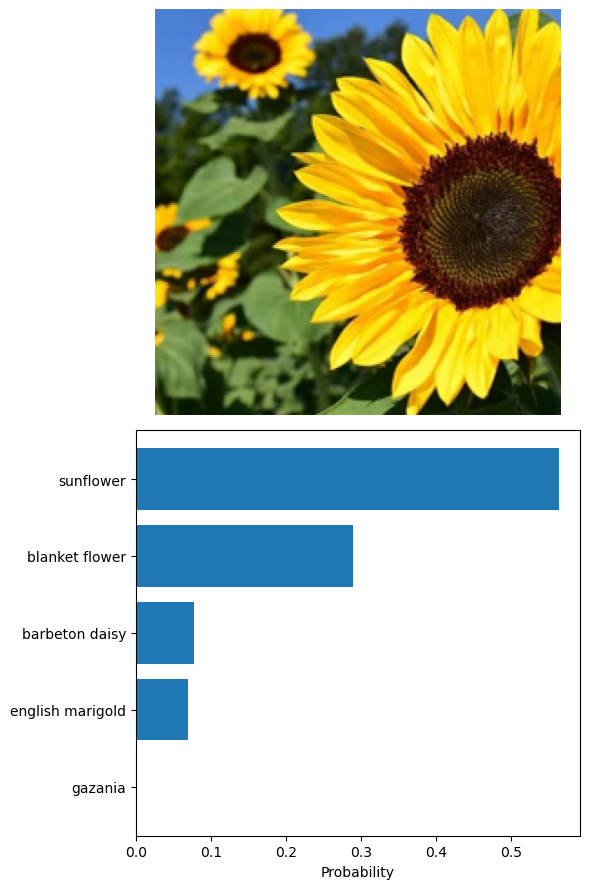

In [34]:
# Display an image along with the top 5 classes
image_path = 'flower_image.jpeg'
probs, classes = predict(image_path, model)
flower_names = [cat_to_name[str(cls)] for cls in classes]
plot_prediction(image_path, probs, classes, flower_names)